This notebook contains a deeper exploration of our fiducial model, including the full evolution with each radius at each timestep

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
import pandas as pd
import vice
import seaborn as sns

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import surp
from surp import gce_math as gcem
from surp.yields import calc_y
import arya

In [30]:
model_dir = "../models/fiducial/run"

In [31]:
fiducial = surp.ViceModel.from_file(model_dir + "/model.json")

In [32]:
yp = surp.yields.YieldParams.from_file(model_dir + "/yield_params.toml")
surp.yields.set_yields(yp)

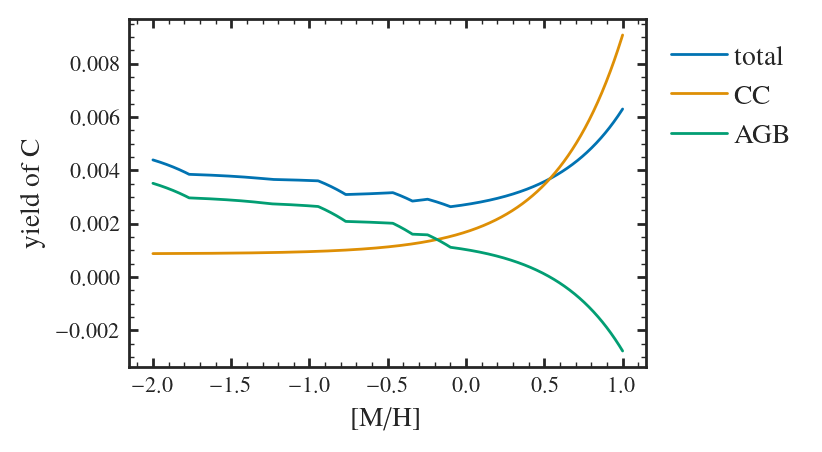

In [33]:
MH = np.linspace(-2, 1, 1000)
Z = gcem.MH_to_Z(MH)
y = calc_y(Z, kind="all")
plt.plot(MH, y, label="total")
y = calc_y(Z, kind="cc")
plt.plot(MH, y, label="CC")

y = calc_y(Z, kind="agb")
plt.plot(MH, y, label="AGB")
plt.xlabel("[M/H]")
plt.ylabel("yield of C")
arya.Legend(-1)

from all the tracks.py

In [34]:
h = fiducial.history

In [35]:
h[np.isclose(h.R, 2 - 0.05)][1:]

,time,mgas,mstar,sfr,ifr,ofr,eta_0,r_eff,z_in(fe),z_in(o),...,N_MG,C_FE,C_O,C_MG,C_N,z,M_H,lookback,R,zone
2645,0.02,12417900.0,5.484123e+04,0.003205,0.624100,0.0,0.0,0.144431,0.0,0.0,...,-0.305588,-0.129229,-0.579074,-0.578613,-0.273025,0.000063,-2.443743,13.18,1.95,19
2646,0.04,15048170.0,1.609289e+05,0.006358,0.137409,0.0,0.0,0.164806,0.0,0.0,...,-0.305588,-0.128246,-0.578091,-0.577630,-0.272042,0.000156,-2.053446,13.16,1.95,19
2647,0.06,16834680.0,3.656816e+05,0.009460,0.097737,0.0,0.0,0.186160,0.0,0.0,...,-0.305588,-0.126929,-0.576774,-0.576313,-0.270725,0.000276,-1.804985,13.14,1.95,19
2648,0.08,18226690.0,7.202513e+05,0.012511,0.080350,0.0,0.0,0.224089,0.0,0.0,...,-0.305588,-0.125288,-0.575133,-0.574673,-0.269084,0.000420,-1.621872,13.12,1.95,19
2649,0.10,19382780.0,1.057289e+06,0.015512,0.070513,0.0,0.0,0.219704,0.0,0.0,...,-0.305562,-0.129422,-0.579267,-0.578806,-0.273244,0.000586,-1.477530,13.10,1.95,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,13.12,83923880.0,6.865081e+08,0.040648,0.009706,0.0,0.0,0.465456,0.0,0.0,...,0.137369,0.003530,0.006050,0.006510,-0.130858,0.045142,0.409070,0.08,1.95,19
3301,13.14,83717730.0,6.878474e+08,0.040520,0.011293,0.0,0.0,0.601287,0.0,0.0,...,0.137451,0.003585,0.006279,0.006740,-0.130711,0.045170,0.409340,0.06,1.95,19
3302,13.16,83512000.0,6.921816e+08,0.040393,0.005742,0.0,0.0,0.587654,0.0,0.0,...,0.137907,0.003412,0.006285,0.006745,-0.131161,0.045255,0.410154,0.04,1.95,19
3303,13.18,83306680.0,6.863461e+08,0.040266,0.006263,0.0,0.0,0.611507,0.0,0.0,...,0.138400,0.003184,0.006187,0.006647,-0.131753,0.045332,0.410888,0.02,1.95,19


In [36]:
import warnings

In [37]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified between (x, y) points by a third value.

    It does this by creating a collection of line segments between each pair of
    neighboring points. The color of each segment is determined by the
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should have a size one less than that of x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Check color array size (LineCollection still works, but values are unused)
    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )

    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mpl.collections.LineCollection(segments, **lc_kwargs)

    # Set the values used for colormapping
    lc.set_array(c)

    return ax.add_collection(lc)

In [38]:
def f_log(x):
    return gcem.abund_ratio_to_brak(x / ymg, "c", "mg")

In [39]:
def f_ilog(x):
    return gcem.brak_to_abund_ratio(x, "c", "mg") * ymg

In [40]:
f_ilog(f_log(0.001))

np.float64(0.001)

In [41]:
ymg = vice.yields.ccsne.settings["mg"]

/tmp/ipykernel_916723/3328111001.py:34: UserWarning: The c argument should have a length one less than the length of x and y. If it has the same length, use the colored_line function instead.
  warnings.warn(


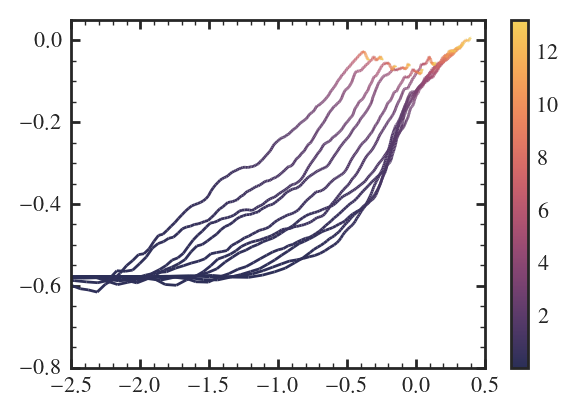

In [42]:
fig, ax = plt.subplots()
for R in np.arange(2, 13):
    df = h[np.isclose(h.R, R - 0.05)][1:]
    x = df.MG_H
    y = df.C_MG
    c = df.time

    lines = colored_line(x, y, c, ax)

    
plt.xlim(-2.5, 0.5)
plt.ylim(-0.8, 0.05)

fig.colorbar(lines)

plt.show()

/tmp/ipykernel_916723/3328111001.py:34: UserWarning: The c argument should have a length one less than the length of x and y. If it has the same length, use the colored_line function instead.
  warnings.warn(


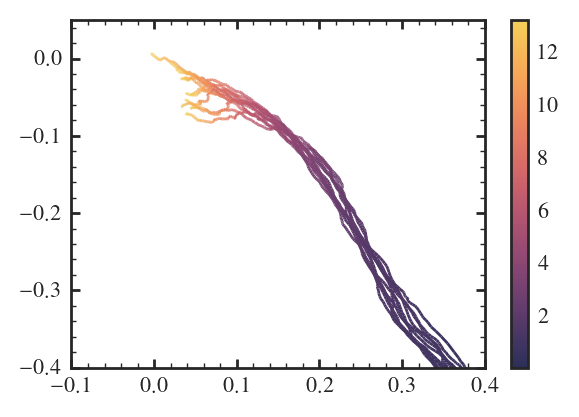

In [43]:
fig, ax = plt.subplots()
for R in np.arange(2, 13):
    df = h[np.isclose(h.R, R - 0.05)][1:]
    x = df.MG_FE
    y = df.C_MG
    c = df.time

    lines = colored_line(x, y, c, ax)

    
plt.xlim(-0.1, 0.4)
plt.ylim(-0.4, 0.05)

fig.colorbar(lines)

plt.show()

![](plots/figures/all_the_tracks.png)

## Quick checks

In [44]:
label_Rs

NameError: name 'label_Rs' is not defined

The plot below is helpful for identifying correct labels for the complete plot above

In [45]:
for R in np.sort(np.sort(h.R.unique())):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    if any(np.isclose(R+0.05, label_Rs)):
        coords.append((
            dfa["MG_FE"].iloc[-1], 
            dfa["C_MG"].iloc[-1]
        ))

        plt.plot(dfa["MG_FE"], dfa["C_MG"], label=f"R = {R:0.2f} kpc", zorder=2, lw=1)

plt.legend()
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

NameError: name 'label_Rs' is not defined

In [46]:
filt = fiducial.history.time == 13.2
filt &= fiducial.history.R > 7
filt &= fiducial.history.R <= 9


In [47]:
sum(fiducial.history.mstar[filt])

5066846100.0

Text(0, 0.5, '[C/Mg]')

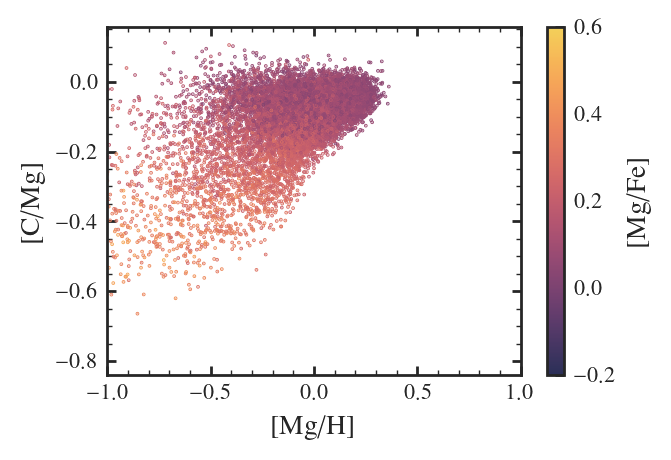

In [48]:
plt.scatter(fiducial.stars.MG_H, fiducial.stars.C_MG, s=0.1, c=fiducial.stars.MG_FE, vmin=-0.2, vmax=0.6)
plt.xlim(-1, 1)
#plt.ylim(-1, 1)
plt.colorbar(label="[Mg/Fe]")
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [49]:
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', arya.COLORS, len(arya.COLORS))

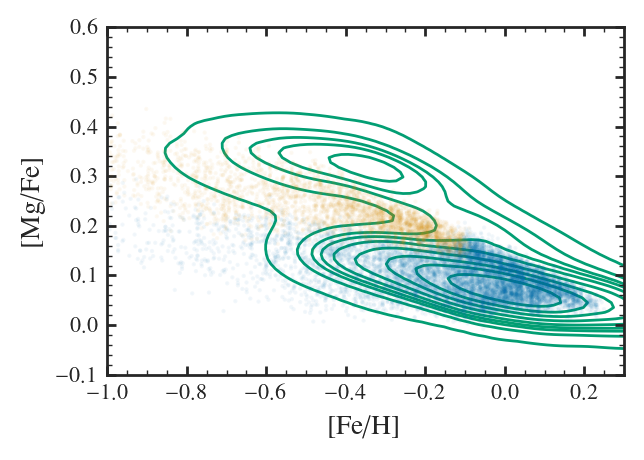

In [50]:
# define the bins and normalize
bounds = np.arange(0, len(arya.COLORS))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(fiducial.stars.FE_H, fiducial.stars.MG_FE, s=0.3, alpha=0.05, c=fiducial.stars.high_alpha, cmap=cmap, norm=norm)




plt.xlim(-1, 0.3)
plt.ylim(-0.1, 0.6)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")

x = np.linspace(-1, 0.3, 1000)
y = surp.gce_math.mg_fe_cutoff(x)
#plt.plot(x, y, color="k")

sns.kdeplot(surp.subgiants, x="FE_H", y="MG_FE", zorder=-1, color=arya.COLORS[2]);



In [51]:
s = fiducial.stars

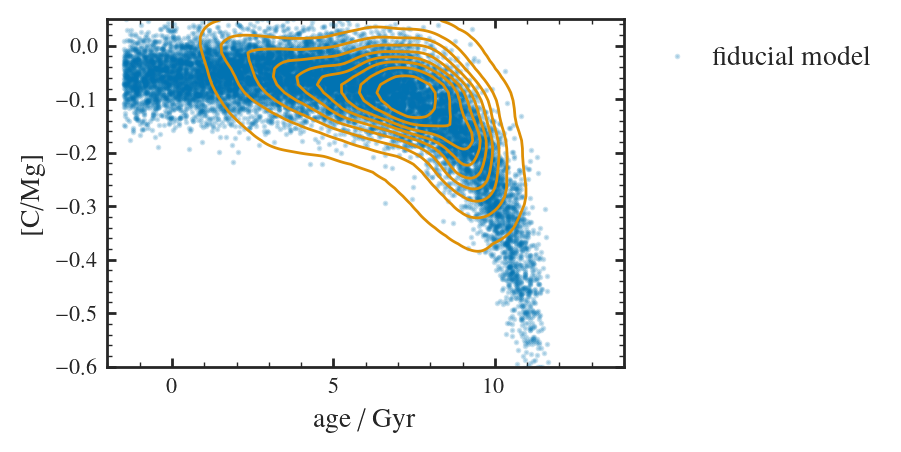

In [54]:
age_shift = 1.5

plt.scatter(s.age - age_shift, s.C_MG, s=1, alpha=0.2, label="fiducial model")
sns.kdeplot(surp.subgiants, x="age_ANN", y="C_MG", zorder=1, color=arya.COLORS[1], label="ANN ages");
plt.xlabel("age / Gyr")
plt.ylabel("[C/Mg]")
plt.xlim(-2, 14)
plt.ylim(-0.6, 0.05)
arya.Legend(-1)

# Other properties
Here, I want to make plots of the AGB Fraction across the galaxy.

In [ ]:
plt.hist(fiducial.stars.r_final, bins=np.arange(4, 10, 0.1),);
plt.hist(surp.subgiants.R_gal, bins=np.arange(4, 10, 0.1), histtype="step")
plt.xlim(5, 10)
plt.xlabel("R final")
plt.ylabel("count")

In [ ]:
plt.hist(fiducial.stars.age, bins=np.arange(0, 14, 0.5),);
plt.hist(surp.subgiants.age_ANN, bins=np.arange(0, 14, 0.5), histtype="step")
plt.xlabel("age")
plt.ylabel("count")

In [ ]:
plt.scatter(fiducial.stars.r_origin, fiducial.stars.M_H, s=0.1, alpha=0.1)
plt.ylim(-2)
plt.xlabel("R birth")
plt.ylabel("[M/H]")

## AGB fraction

In [ ]:
R_max = 15.5

h = fiducial.history[fiducial.history.R < R_max]
h = h.sort_values(["zone", "time"])

R = np.sort(np.unique(h.R))
t = np.sort(np.unique(h.time))

m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = np.mean(np.diff(t)) # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = np.vectorize(y_cc)(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (len(R), len(t)))

In [ ]:
max(f_agb[f_agb < 0.5])

In [ ]:
Xx = np.reshape(h.zone, (len(R), len(t)))
np.transpose(Xx)[-1, :]

In [ ]:
plt.plot(R, np.transpose(X)[-1,:])
plt.ylim(-0.5, 1)
plt.xlim(0.5)
plt.xlabel("zone")
plt.ylabel("f agb")

In [ ]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.6), extent=(np.min(R), np.max(R), np.min(t), np.max(t)), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t) = y^{\rm AGB} / y^{\rm tot} (t)$")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

## other chemistry plots & the bimodality

In [ ]:
s = fiducial.stars

sns.kdeplot(surp.subgiants[~np.isnan(surp.subgiants.N_MG)], x="MG_H", y="N_MG")
plt.scatter(s["MG_H"], s["N_MG"], 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")


The plots below illustrate a possible alternative setup, where we instead show the median 

In [ ]:
sns.kdeplot(s, x="MG_FE", y="C_MG");
plt.xlim(-0.1, 0.5)
plt.ylim(-0.6, 0.1)

In [ ]:
plt.hist2d(fiducial.stars.FE_H, fiducial.stars.MG_FE, range=((-1, 1),( -1, 1)), bins=100 )
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.4)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.8, 0.5)
plt.ylim(-0.1, 0.5)

In [ ]:
plt.scatter(surp.subgiants.FE_H, surp.subgiants.MG_FE, s=1, alpha=0.1)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.5)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.1, 0.5)
plt.title("subgiants")

In [ ]:
sns.kdeplot(fiducial.stars, x="FE_H", y="MG_FE", clip=((-1, 1), (-1, 1)));

In [ ]:
sns.kdeplot(surp.filter_metallicity(s), x="FE_H", y="MG_FE");

In [ ]:
sns.kdeplot(surp.filter_metallicity(surp.subgiants), x="FE_H", y="MG_FE");

In [ ]:
sns.kdeplot(surp.filter_metallicity(s), x="MG_FE", y="C_MG");

In [ ]:
sns.scatterplot(surp.filter_metallicity(s), x="MG_FE_true", y="C_MG_true", alpha=0.2);

In [ ]:
sns.scatterplot(surp.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);

In [ ]:
#sns.scatterplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);
sns.kdeplot(surp.filter_metallicity(surp.subgiants), x="MG_FE", y="C_MG",)

## Understanding Mg/Fe | Mg/H

In [ ]:
h = fiducial.history


sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="MG_H", y="MG_FE", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-2.5, 0.5)
#plt.ylim(-0.45, 0.05)
#surp.plots.plot_annulus_at_t(fiducial, "MG_H", "C_MG", t=2, zorder=-2)
plt.axvline(-0.1)


The plot below shows the region in parameterspace our selection in metallicity chooses.
Because the inner galaxy evolution is fairly homogenous, these regions reach \[M/H\] ~ -0.1 quickly and with a \[Mg/Fe\] on the plateau. However, at higher radii, the time to reach this metallicity takes longer and so SNeIa have time to decrease the \[Mg/Fe\] ratio, so the metallicity selection keeps stars with lower alpha/Fe abundances and born later in the galaxy. As such, \[Mg/Fe\] becomes a proxy for time when selected by metallicity, so the C-Mg/Mg-Fe trend should approximate SSP evolution in C/Mg with time.

In [ ]:
filt = (h.R > 2) & (h.R < 15.5)
filt &= h.MG_H > -0.15
filt &= h.MG_H < -0.05

sns.scatterplot(h[filt], x="R", y="MG_FE", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)


In [ ]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), ax=plt.gca(), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    df = surp.filter_metallicity(s, c=MH, w=0.05)

    Cm = np.median(df.C_MG[~df.high_alpha])

    df["C_Cm"] = df.C_MG - Cm

    #plt.scatter(0, Cm, color=cb(MH))
    N = len(df)
    Npb = 10 * round(N**(2/5))
    print(Npb)
    
    arya.medianplot(df, x="MG_FE", y="C_Cm", binsize=Npb, color=cb(MH), aes="scatter", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/median C]")


In [ ]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), ax=plt.gca(), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    df = surp.filter_metallicity(s, c=MH)
    N = len(df)
    Npb = 10 * round(N**(2/5))
    print(Npb)
    
    arya.medianplot(df, x="MG_FE", y="C_MG", binsize=Npb, color=cb(MH), aes="scatter", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")